<a href="https://colab.research.google.com/github/Carmen-GL/repo_master_/blob/main/Time_series_prediction_LSTM_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline passengers prediction using LSTM in Keras

In [8]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [13]:
# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset.shape


(144, 1)

In [14]:
print(dataframe)

     Passengers
0           112
1           118
2           132
3           129
4           121
..          ...
139         606
140         508
141         461
142         390
143         432

[144 rows x 1 columns]


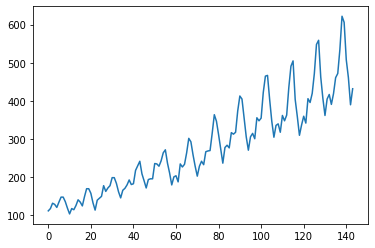

In [15]:
plt.plot(dataset)
plt.show()

In [18]:
# normalize the dataset between [0,1]
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [20]:
# Function to convert an array of values into a dataset matrix.
# By default create_dataset will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
# So the time step is 1 by default, and at a fixed time step we will use "lag" features

def create_dataset(dataset, lag=1):  # lag is the number of previous values to consider for predicting next one
	dataX, dataY = [], []
	for i in range(len(dataset)-lag):
		a = dataset[i:(i+lag), 0] # slice of "lag" length starting at i
		dataX.append(a)
		dataY.append(dataset[i + lag, 0]) # target = next time step
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# First way for building the dataset: First split in train/test, then apply lags to create the matrices

# split into train and test sets
#train_size = int(len(dataset) * 0.67)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train), len(test))

# build matrices
#lag = 1
#trainX, trainY = create_dataset(train, lag)
#testX, testY = create_dataset(test, lag)
#print(trainX.shape)
#print(testX.shape)
#print(trainX[0:5])
#print(trainY[0:5])

In [25]:
# Another way for building the dataset: First build the lag matrix, then split in train/test
# In this way we keep continuity between the sets and do not waste samples.
lag=1 #si ponemos un lag de 3 coge 3 features para predecir la siguiente
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

dataX, dataY = create_dataset(dataset, lag=1)
trainX, trainY = dataX[0:train_size,:], dataY[0:train_size]
testX, testY = dataX[train_size:len(dataset),:], dataY[train_size:len(dataset)]
print(trainX.shape)
print(testX.shape)
print(trainX[0:5])
print(trainY[0:5])

(96, 1)
(47, 1)
[[0.01544189]
 [0.02702713]
 [0.05405426]
 [0.04826164]
 [0.03281784]]
[0.02702713 0.05405426 0.04826164 0.03281784 0.05984497]


In [26]:
# reshape inputs to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [27]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag)))  #input_shape= time steps, features
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer= 'adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
96/96 [==============================] - 4s 3ms/step - loss: 0.0293
Epoch 2/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 3/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 4/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 5/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 6/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 7/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 8/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 9/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 10/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 11/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 12/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 13/50
96/96 [==============================

In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.27 RMSE
Test Score: 0.55 RMSE


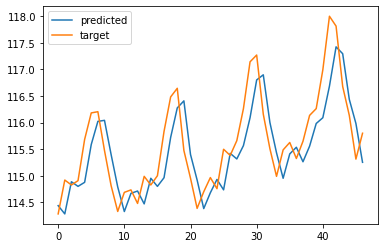

In [29]:
plt.plot(testPredict, label='predicted')
plt.plot(testY[0], label='target')
plt.legend()
plt.show()

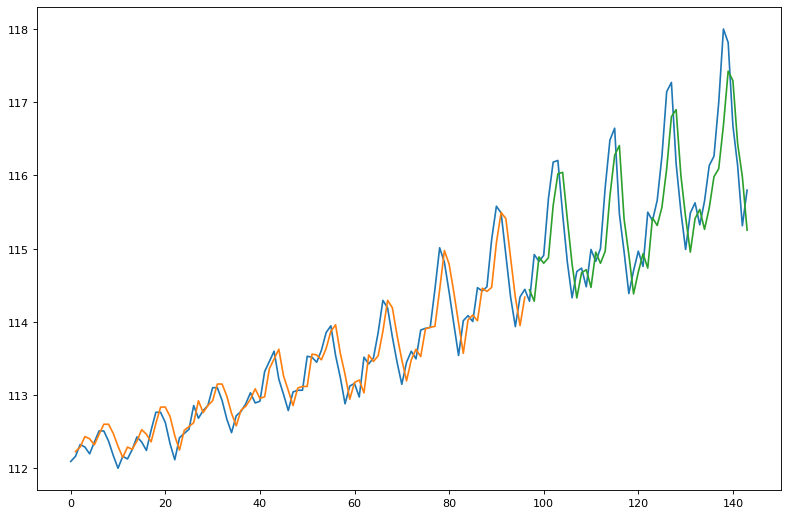

In [34]:
# Optional: plot train and test predictions in the same graph in different colors.
# We must shift train and test predictions to the correct position.
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(lag*2)-1:len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()